In [1]:
from jax_circuits import *
from scipy.stats import unitary_group
import matplotlib.pyplot as plt

import time
import pickle

from qiskit import transpile
from qiskit.quantum_info import Operator

from topology import *

from jax import custom_jvp, jvp, grad
from jax.scipy.optimize import minimize

key = random.PRNGKey(0)

# Trigonometric landscape

First we will define a generator of trigonometric functions and a procedure to compute exact average.

In [10]:
def int_to_list(n, size):
    n_str = format(n, 'b')
    assert len(n_str)<=size, 'Integer {} too big to be converted to size {}'.format(n, size)
    
    zero_pad = '0'*(size-len(n_str))
    n_str = zero_pad + n_str
    
    return [int(b) for b in n_str]

def all_binary_strings(size):
    max_n = int('1'*size, 2)+1
    return [int_to_list(n, size) for n in range(max_n)]


def trigonometric_landscape(coeffs, n_angles):

#     assert n_angles % 1 == 0, 'Number of coefficients must be 2**n, got len(coeffs) {}'.format(len(coeffs))
    powers = 1-jnp.array(all_binary_strings(int(n_angles)))

    def f(angles):
        cos_sin_array = jnp.cos(angles/2)**powers * jnp.sin(angles/2)**(1-powers)
        cos_sin_monomials = jnp.prod(cos_sin_array, axis=1)
        
        return (coeffs*cos_sin_monomials).sum()
    
    return f

This should illustrate what this function is doing.

CPU times: user 424 ms, sys: 22.5 ms, total: 447 ms
Wall time: 440 ms


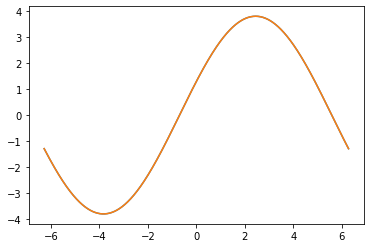

In [11]:
%%time
coeffs0=jnp.array([1, 2, 3, 4], dtype='float32')
n_angles0 = int(jnp.log2(len(coeffs0)))

f0 = trigonometric_landscape(coeffs0, n_angles0)

x_sweep = jnp.linspace(-2*jnp.pi, 2*jnp.pi, 1000)
y = 0.3

plt.plot(x_sweep, vmap(lambda x: f0(jnp.array([x, y], dtype='float32')))(x_sweep))
plt.plot(x_sweep, jnp.cos(x_sweep/2)*jnp.cos(y/2)+
         2*jnp.cos(x_sweep/2)*jnp.sin(y/2)+
         3*jnp.sin(x_sweep/2)*jnp.cos(y/2)+
         4*jnp.sin(x_sweep/2)*jnp.sin(y/2))

In [12]:
def exact_average(F, n_angles):
    grid_points = jnp.pi*jnp.array(all_binary_strings(n_angles))
    F_grid = vmap(F)(grid_points)
    
    return F_grid.sum()/len(grid_points)

def approximate_average(F, n_angles, n_samples, key):
    grid_points = jnp.pi*jnp.array(all_binary_strings(n_angles))
    grid_points = random.permutation(key, grid_points)
    grid_points = grid_points[:n_samples]
    
    F_grid = vmap(F)(grid_points)
    
    return F_grid.sum()/len(grid_points)

Test.

In [13]:
key, subkey = random.split(key)
n_angles = 10
coeffs = random.uniform(subkey, shape=(2**n_angles, ), minval=0, maxval=1)


print((coeffs**2).sum()/2**n_angles)
print(exact_average(lambda angles: trigonometric_landscape(coeffs, n_angles)(angles)**2, n_angles))

0.34455547
0.34455538


In [14]:
%%time
n_angles = 12
key, subkey = random.split(key)
coeffs = random.uniform(subkey, shape=(2**n_angles, ), minval=0, maxval=1)
exact_avg = (coeffs**2).sum()/2**n_angles
F = lambda angles: trigonometric_landscape(coeffs, n_angles)(angles)**2
F=jit(F)

average_list = []
for i in range(n_angles):
    key, subkey = random.split(key)
    average_i = approximate_average(F, n_angles, 2**i, subkey)
    average_list.append(average_i)

CPU times: user 9.19 s, sys: 61 ms, total: 9.26 s
Wall time: 5.51 s


number of angles: 12


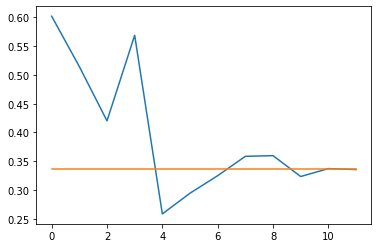

In [15]:
print('number of angles: {}'.format(n_angles))
plt.plot(average_list)
plt.plot([exact_avg]*n_angles)

# Average conjecture test

Now we can test the average conjecture.

In [136]:
n_qubits = 3
a = Ansatz(n_qubits, 'cx', placements={'free':[[1,2], [0,1],[0, 2]]})
# u_func = lambda angs: a.unitary(jnp.array([angs[0], 0, 0, 0, 0, 0], dtype='float32'))
zero_angles = jnp.zeros((a.n_angles, ))
restrinced_angles = lambda angs: zero_angles.at[9].set(angs[0]).at[15].set(angs[1])
u_func = lambda angs: a.unitary(restrinced_angles(angs))
n_angles = 1
a.circuit(restrinced_angles((1, 2))).draw()

┌───────┐┌───────┐┌───────┐                            ┌───────┐┌───────┐»
q_0: ┤ RZ(0) ├┤ RX(0) ├┤ RZ(0) ├─────────────────────────■──┤ RY(0) ├┤ RX(0) ├»
     ├───────┤├───────┤├───────┤     ┌───────┐┌───────┐┌─┴─┐├───────┤├───────┤»
q_1: ┤ RZ(0) ├┤ RX(0) ├┤ RZ(0) ├──■──┤ RY(1) ├┤ RX(0) ├┤ X ├┤ RY(2) ├┤ RX(0) ├»
     ├───────┤├───────┤├───────┤┌─┴─┐├───────┤├───────┤└───┘└───────┘└───────┘»
q_2: ┤ RZ(0) ├┤ RX(0) ├┤ RZ(0) ├┤ X ├┤ RY(0) ├┤ RX(0) ├───────────────────────»
     └───────┘└───────┘└───────┘└───┘└───────┘└───────┘                       »
«          ┌───────┐┌───────┐
«q_0: ──■──┤ RY(0) ├┤ RX(0) ├
«       │  └───────┘└───────┘
«q_1: ──┼────────────────────
«     ┌─┴─┐┌───────┐┌───────┐
«q_2: ┤ X ├┤ RY(0) ├┤ RX(0) ├
«     └───┘└───────┘└───────┘

In [141]:
def A_and_B(angles):
    n_angles = len(angles)
    R = 1j*jnp.kron(y_mat, jnp.identity(2**(n_qubits-1)))
    
    W0 = u_func(jnp.zeros((n_angles), dtype='float32'))
    W = u_func(angles)
    
    A = trace_prod(W0, W)
    B = trace_prod(W0, R@W)
    
    return A, B

def A_squared(angles):
    A, _ = A_and_B(angles)
    return A*A.conj()

def B_squared(angles):
    _, B = A_and_B(angles)
    return B*B.conj()

def A_bar_B(angles):
    A, B = A_and_B(angles)
    return A*B.conj()

In [142]:
print(exact_average(A_squared, n_angles))
print(exact_average(B_squared, n_angles))
print(exact_average(A_bar_B, n_angles))

(16+0j)
0j
0j


# Average learning

In [16]:
def optimize_first_angle(f, n_angles, average_func):
    if n_angles == 1:
        return min_angle(lambda ang: f(jnp.array((ang, ))))
    
    def f_to_average(ang, angs):
        angles = jnp.concatenate([jnp.array([ang]), angs])
        return f(angles)
    
    def f1(ang):
        return average_func(lambda angs: f_to_average(ang, angs), n_angles-1)
    
    return min_angle(f1)

def average_learn(u_func, u_target, n_angles, average_func):
    
    def loss0(angles):
        return disc2(u_func(angles), u_target)
    
    optimal_angles = jnp.array([], dtype='float32')
    for n in range(n_angles):
        def loss(angs):
            angles = jnp.concatenate([optimal_angles, angs])
            return loss0(angles)
        n_angs = n_angles - n
        new_angle = optimize_first_angle(loss, n_angs, average_func)
        optimal_angles = jnp.append(optimal_angles, new_angle)

    return optimal_angles

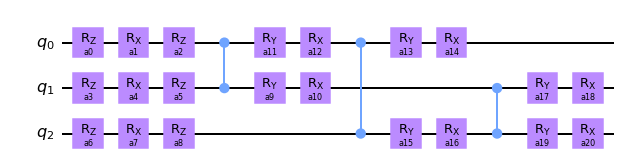

In [114]:
a = Ansatz(3, 'cz', placements={'free':[[1,0], [0, 2], [1, 2]]})
u_target = a.unitary(jnp.array(range(1, a.n_angles+1), dtype='float32'))
a.circuit().draw(output='mpl')

In [115]:
u_restricted = lambda angs: a.unitary(jnp.concatenate([jnp.zeros(shape=(9,)), angs]))
u_target_restricted = u_restricted(jnp.array(range(0, a.n_angles-9),dtype='float32'))

In [116]:
opt_angles = average_learn(u_restricted, u_target_restricted, a.n_angles-9, exact_average)

In [117]:
print(opt_angles)
print(disc2(u_restricted(opt_angles),u_target_restricted))

[ 1.5707964   1.5707964  -0.         -0.         -0.9375348   1.9304514
  0.7853982  -1.5707964   1.5391778  -0.42477575  1.2185782   3.5698256 ]
0.68964493


In [89]:
W = rz_mat(3) @ rx_mat(2) @ rz_mat(1)
Vmats = [W, z_mat @ W, x_mat @ W, x_mat @ z_mat @ W]
total = 0
for V in Vmats:
    total += jnp.trace(V.conj().T)*jnp.trace(V@z_mat)-jnp.trace(V)*jnp.trace(V.conj().T@z_mat)
total

DeviceArray(0.+0.j, dtype=complex64)

In [94]:
total = 0
for V in Vmats:
    total += jnp.abs(jnp.trace(V.conj().T))**2-jnp.abs(jnp.trace(V.conj().T@z_mat))**2
total

DeviceArray(0., dtype=float32)

In [80]:
jnp.trace(jnp.identity(4))

DeviceArray(4., dtype=float32)

In [21]:
ah, lh = a.learn(u_target)

In [22]:
ah[-1]

DeviceArray([4.1415873 , 4.283187  , 2.999997  , 4.0009146 , 1.8587089 ,
             3.4250803 , 0.71681476, 1.7168156 , 5.85841   , 3.7168412 ],            dtype=float32)

In [23]:
lh[-1]

DeviceArray(0., dtype=float32)